In [1]:
import os
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
import scipy.stats as stats

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from scipy.special import boxcox1p

import xgboost as xgb
import lightgbm as lgb
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Lasso
from sklearn.linear_model import BayesianRidge
from sklearn.linear_model import LassoLarsIC
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin
from sklearn.base import RegressorMixin
from sklearn.base import clone
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

df_train = pd.read_csv("../input/train.csv")
df_test = pd.read_csv("../input/test.csv")
all_dfs = [df_train,df_test]
test_ids = df_test['Id']

def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn
warnings.filterwarnings('ignore')

#from sklearn.preprocessing import LabelEncoder may be more scalable and maintainable in most situations
def makeOrdinal(df,label,showDict=False):
    filtered = df.sort_values([label], ascending = [True])
    df_filtered = filtered.groupby(label).first().reset_index()
    strcat_dict = {}
    
    for i,row in df_filtered.iterrows():
        strcat_dict[row[label]] = i 
    
    if showDict:
        print(strcat_dict)
    
    for j,row in df.iterrows():
        df.at[j,label] = strcat_dict.get(row[label])
    
    return df[label]

def bucketData(df,column_to_bucket):
    number_of_buckets = 5
    df['tempBand'] = pd.qcut(df[column_to_bucket],number_of_buckets)
    intervals = df['tempBand'].unique().sort_values().tolist()
    intervals = [x for x in intervals if str(x) != 'nan']
    
    interval_dict = {}
    for idx,interval in enumerate(intervals):
        interval_dict['low'+str(idx)] = interval.left
        interval_dict['high'+str(idx)] = interval.right
    
    df.loc[ df[column_to_bucket] <= interval_dict['high0'], column_to_bucket] = 0
    df.loc[(df[column_to_bucket] > interval_dict['low1']) & \
           (df[column_to_bucket] <= interval_dict['high1']), column_to_bucket] = 1
    df.loc[(df[column_to_bucket] > interval_dict['low2']) & \
           (df[column_to_bucket] <= interval_dict['high2']), column_to_bucket] = 2
    df.loc[(df[column_to_bucket] > interval_dict['low3']) & \
           (df[column_to_bucket] <= interval_dict['high3']), column_to_bucket] = 3
    df.loc[ df[column_to_bucket] > interval_dict['low4'], column_to_bucket] = 4
    
    df = df.drop(['tempBand'], axis=1)

def spearman(frame, features):
    spr = pd.DataFrame()
    spr['feature'] = features
    spr['spearman'] = [frame[f].corr(frame['SalePrice'], 'spearman') for f in features]
    spr = spr.sort_values('spearman')
    print(spr)
    plt.figure(figsize=(6, 0.25*len(features)))
    sns.barplot(data=spr, y='feature', x='spearman', orient='h')

def plotMissing(df):
    sns.set_style("whitegrid")
    missing = df.isnull().sum()
    missing = missing[missing > 0]
    missing.sort_values(inplace=True,ascending=False)
    missing.plot.bar()

def missingList(df):
    missing = df.isnull().sum()
    missing = missing[missing > 0]
    missing.sort_values(inplace=True)
    return missing

def dropCols(df,iter_list_to_drop,percentage_qualify=0.9,show_dropped=False):
    drop_cols = []
    for col_name,num_missing in iter_list_to_drop.iteritems():
        if num_missing > (len(df)*percentage_qualify):
            drop_cols.append(col_name)
    
    df.drop(drop_cols,inplace=True, axis=1)
    if show_dropped:
        print('dropped the following columns: ',drop_cols)
    
print("imports and method declarations complete")

imports and method declarations complete


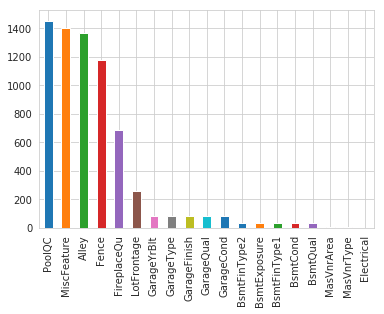

In [2]:
plotMissing(df_train)

In [3]:
#80% threshold makes it ok to drop these columns, too much data missing to make these useful
#also drop Id while we're at it, as it isn't useful in analysis
for df in all_dfs:
    dropCols(df,missingList(df),0.8,True)
    df.drop('Id',inplace=True, axis=1)

all_dfs = [df_train,df_test]

dropped the following columns:  ['Fence', 'Alley', 'MiscFeature', 'PoolQC']
dropped the following columns:  ['Fence', 'Alley', 'MiscFeature', 'PoolQC']


In [4]:
quantitative = [f for f in df_train.columns if df_train.dtypes[f] != 'object']
qualitative = [f for f in df_train.columns if df_train.dtypes[f] == 'object']
quantitative.remove('SalePrice')
all_features = quantitative + qualitative

print('number of quantitative features: ',len(quantitative))
print('number of qualitative features: ',len(qualitative))

number of quantitative features:  36
number of qualitative features:  39


In [5]:
for column in qualitative:
    for df_single in all_dfs:
        makeOrdinal(df_single,column,False)

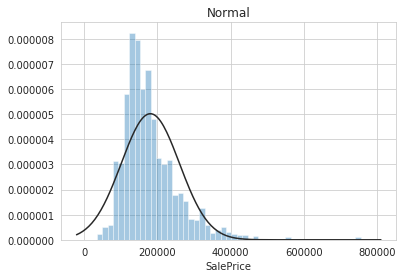

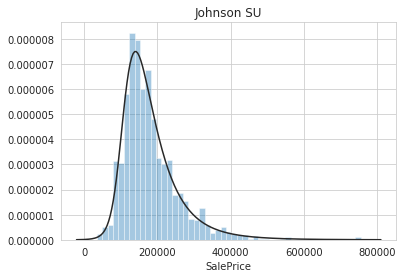

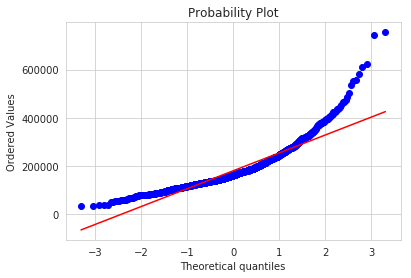

In [6]:
#SalePrice is not 'normally' distributed
y = df_train['SalePrice']
plt.figure(1); plt.title('Normal')
sns.distplot(y, kde=False, fit=stats.norm)

plt.figure(2); plt.title('Johnson SU')
sns.distplot(y, kde=False, fit=stats.johnsonsu)

#if the SalePrice were 'Normally' distributed, it would fit the linear line nicely
#it does not fit however, so is more proof we need to adjust this feature before predicting
fig = plt.figure()
res = stats.probplot(df_train['SalePrice'], plot=plt)
plt.show()


 mu = 11.86 and sigma = 0.78



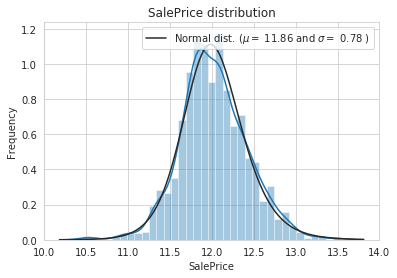

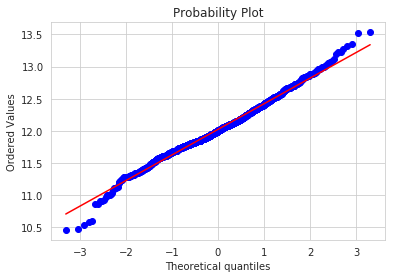

In [7]:
#make the target fit the normal distribution, using log1p function to normalise
df_train["SalePrice"] = np.log1p(df_train["SalePrice"])

#Check that it now fits (use johnsonsu distribution, since it fit nicely earlier)
sns.distplot(df_train['SalePrice'] , fit=stats.johnsonsu);

# Get the fitted parameters (mu and sigma) used by the function
(skew, kurt,mu, sigma) = stats.johnsonsu.fit(df_train['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

fig = plt.figure()
res = stats.probplot(df_train['SalePrice'], plot=plt)
plt.show()

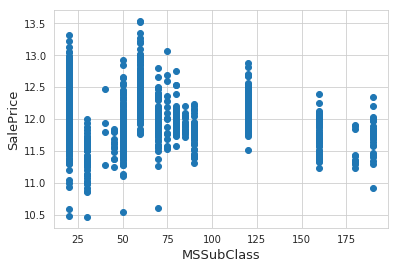

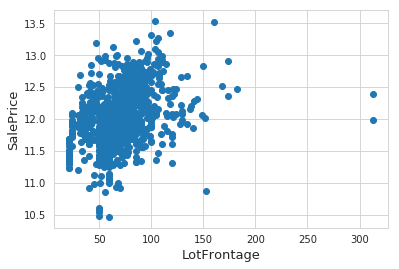

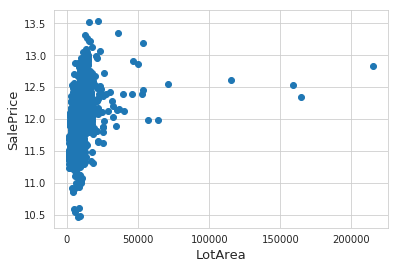

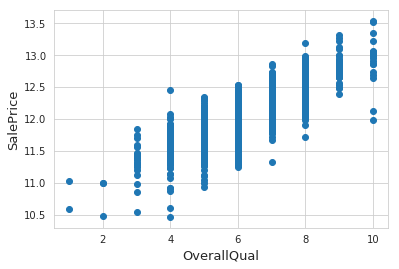

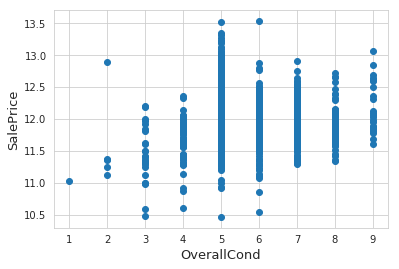

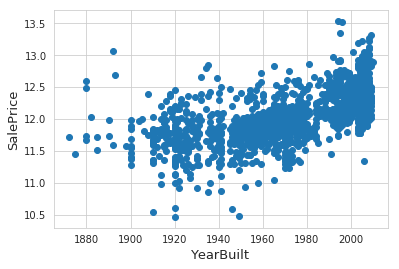

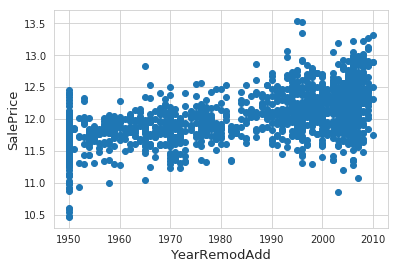

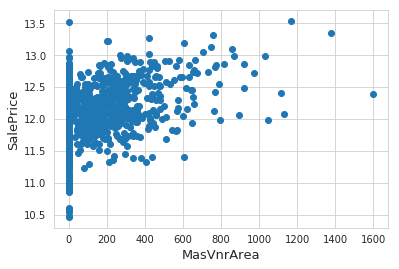

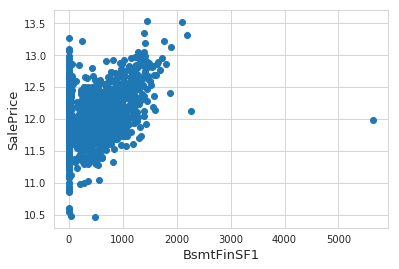

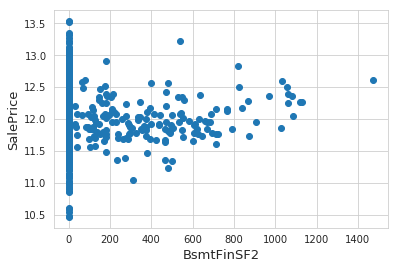

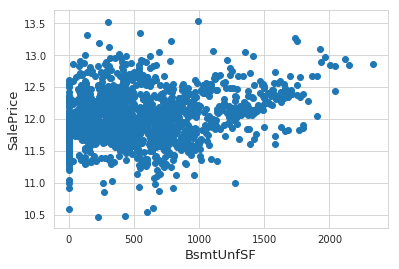

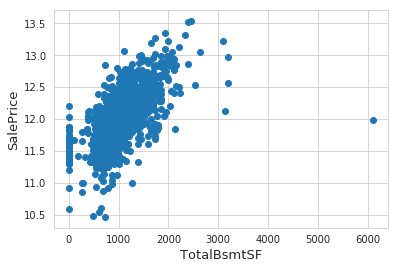

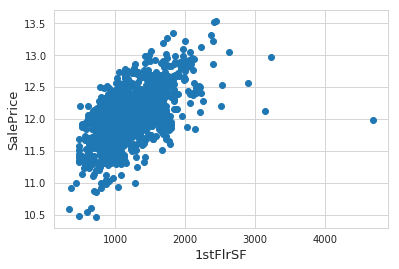

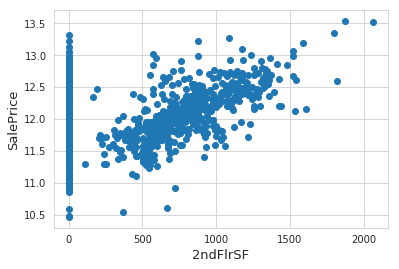

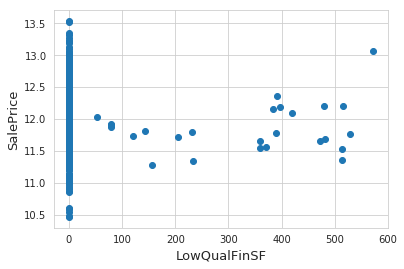

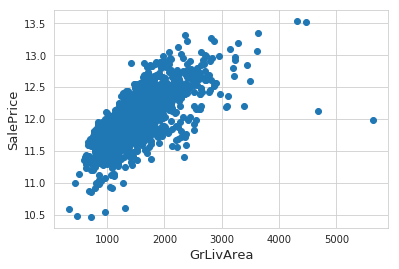

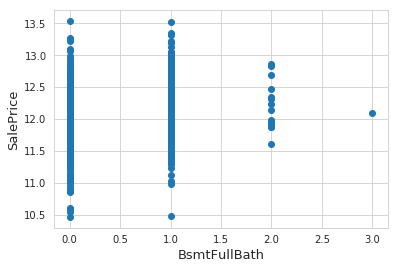

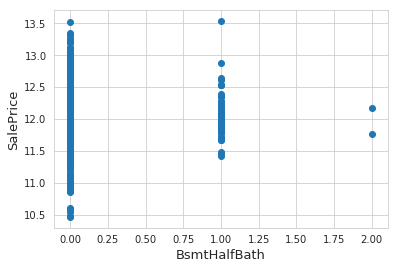

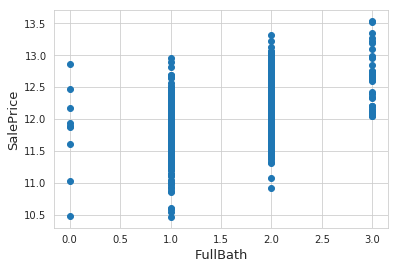

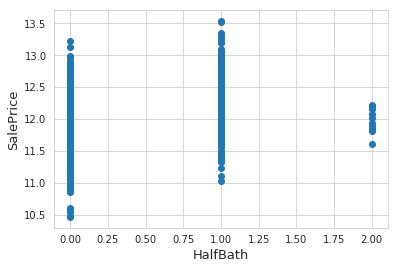

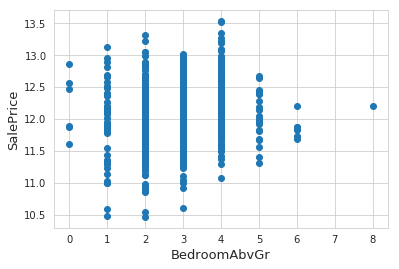

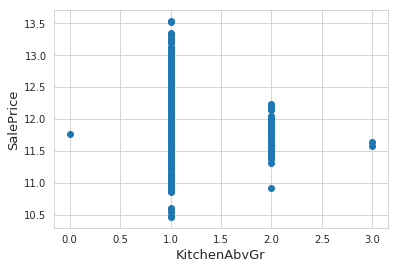

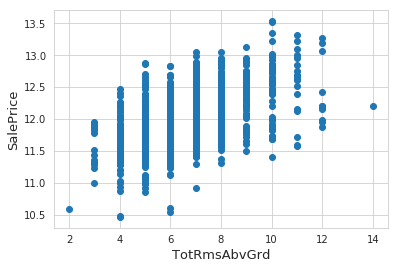

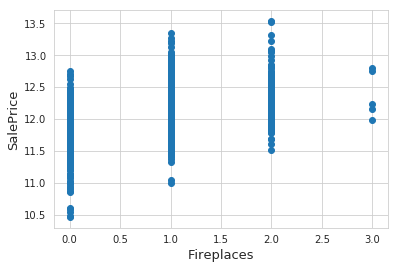

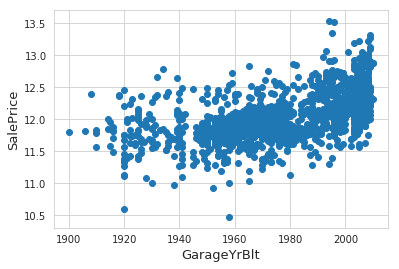

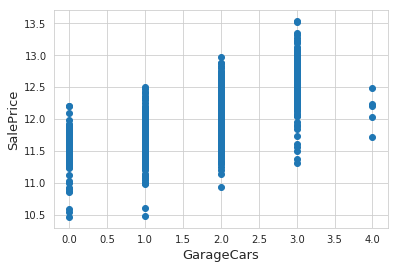

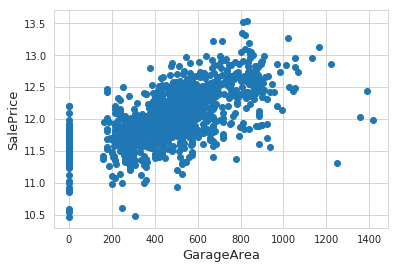

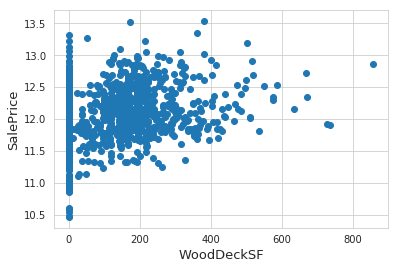

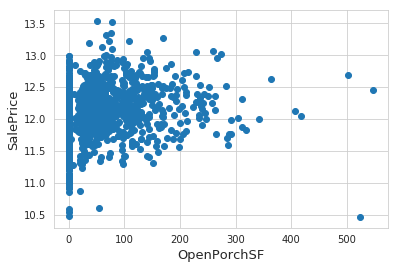

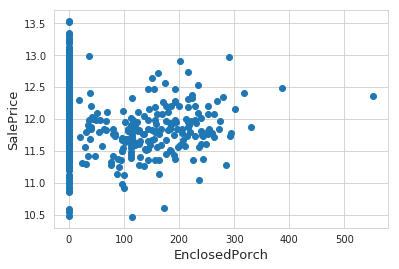

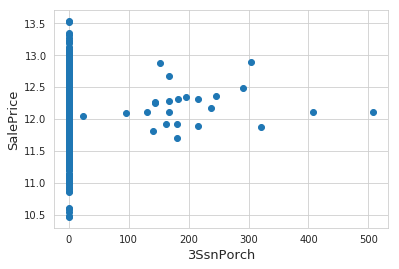

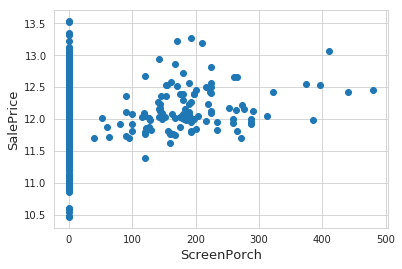

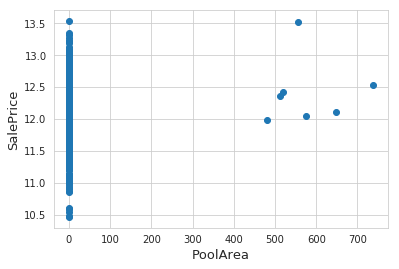

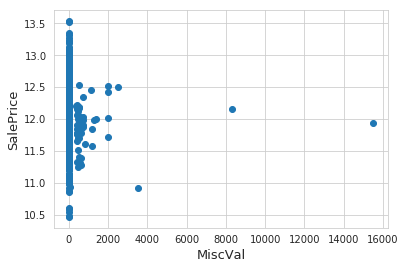

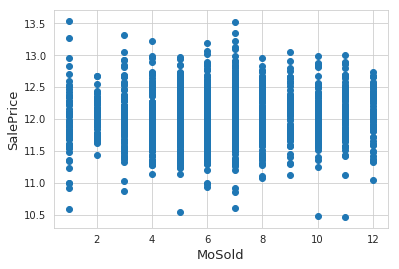

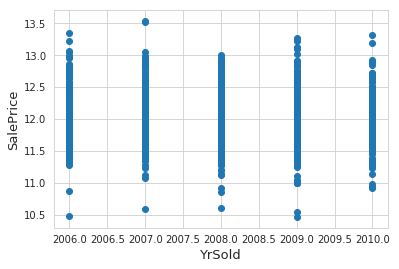

In [8]:
#so we can see if there are any outliers against the SalePrice
for column in quantitative:
    plt.scatter(df_train[column],df_train['SalePrice'])
    plt.ylabel('SalePrice', fontsize=13)
    plt.xlabel(column, fontsize=13)
    plt.show()

#ToDo: method to tell if data in a column is continuous or discrete

In [9]:
#remove a small number of outliers from the training data only .index
print(np.shape(df_train))
#gr_del_loc = df_train[(df_train['GrLivArea']>4000) & (df_train['SalePrice']<300000)].index
#stf_loc = df_train[(df_train['1stFlrSF']>4000) & (df_train['SalePrice']<300000)].index
#df_train.drop(df_train[(df_train['LotFrontage']>300) & (df_train['SalePrice']<300000)].index, inplace=True)

#drop_rows = [523, 691, 1182, 1298, 934]
#df_train = df_train.drop(drop_rows)

print(np.shape(df_train))

(1460, 76)
(1460, 76)


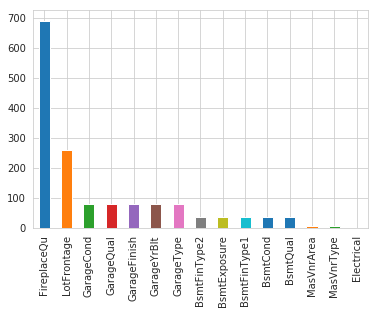

In [10]:
plotMissing(df_train)

          feature  spearman
29  EnclosedPorch -0.218394
21   KitchenAbvGr -0.164826
4     OverallCond -0.129325
14   LowQualFinSF -0.067719
33        MiscVal -0.062727
9      BsmtFinSF2 -0.038806
35         YrSold -0.029899
17   BsmtHalfBath -0.012189
0      MSSubClass  0.007192
32       PoolArea  0.058453
30      3SsnPorch  0.065440
34         MoSold  0.069432
31    ScreenPorch  0.100070
10      BsmtUnfSF  0.185197
16   BsmtFullBath  0.225125
20   BedroomAbvGr  0.234907
13       2ndFlrSF  0.293598
8      BsmtFinSF1  0.301871
19       HalfBath  0.343008
27     WoodDeckSF  0.353802
1     LotFrontage  0.409076
7      MasVnrArea  0.421309
2         LotArea  0.456461
28    OpenPorchSF  0.477561
23     Fireplaces  0.519247
22   TotRmsAbvGrd  0.532586
6    YearRemodAdd  0.571159
12       1stFlrSF  0.575408
24    GarageYrBlt  0.593788
11    TotalBsmtSF  0.602725
18       FullBath  0.635957
26     GarageArea  0.649379
5       YearBuilt  0.652682
25     GarageCars  0.690711
15      GrLivArea  0

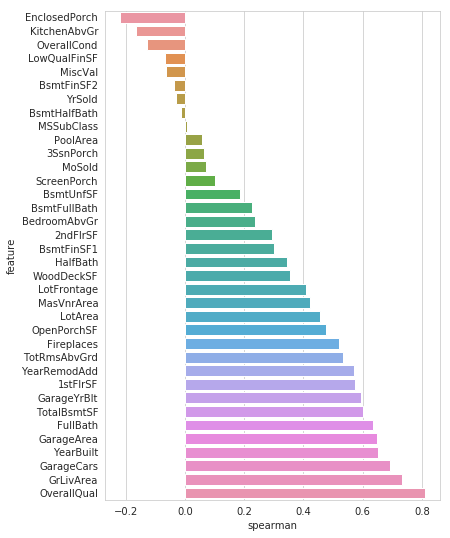

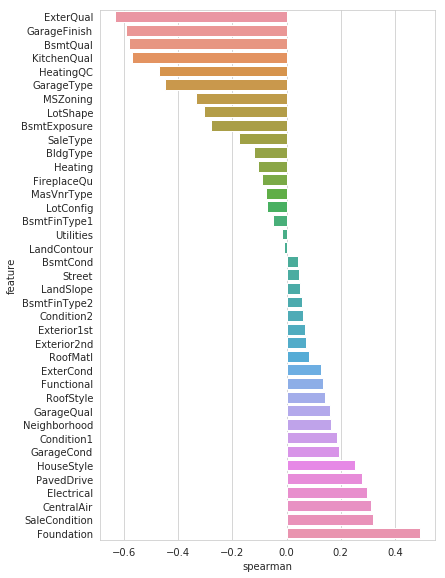

In [11]:
#check correlations
spearman(df_train,quantitative)
spearman(df_train,qualitative)

In [12]:
#impute
feature_imputer = SimpleImputer(strategy='median')

hold_columns = df_train[all_features].columns
df_train[all_features] = pd.DataFrame(feature_imputer.fit_transform(df_train[all_features].values))
df_test[all_features] = pd.DataFrame(feature_imputer.transform(df_test[all_features].values))
df_train[all_features].columns = hold_columns

for df in all_dfs:
    df['TotalSF'] = df['TotalBsmtSF'] + df['1stFlrSF'] + df['2ndFlrSF']

#if we need to convert stuff to int later for the imputer/scaler/models
#float_cols = [cname for cname in df_train.columns if df_train[cname].dtype in ['float64']]
#float_cols = float_cols.remove('SalePrice')
#df_train[float_cols] = df_train[float_cols].astype(int)
#df_test[float_cols] = df_test[float_cols].astype(int)

all_dfs = [df_train,df_test]

In [13]:
# Check the skewness of the quantitative features (test data looks similar, I applied the same test then deleted it)
skewed_features = df_train[all_features].apply(lambda x: stats.skew(x.dropna())).sort_values(ascending=False)

print(len(skewed_features))
skewed_features = skewed_features + \
df_test[all_features].apply(lambda x: stats.skew(x.dropna())).sort_values(ascending=False)
print(len(skewed_features))
print("\nSkew in quantitative features: \n")
skewness = pd.DataFrame({'Skew' :skewed_features})
skewness.head(10)

75
75

Skew in quantitative features: 



,Skew
1stFlrSF,2.931934
2ndFlrSF,1.724138
3SsnPorch,22.805088
BedroomAbvGr,0.647747
BldgType,4.386107
BsmtCond,-6.764678
BsmtExposure,-2.433124
BsmtFinSF1,2.848880
BsmtFinSF2,8.289684
BsmtFinType1,-0.020945


In [14]:
skewness = skewness[abs(skewness) > 0.75]
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

skewed_features = skewness.index
lam = 0.15
for df in all_dfs:
    for feature in skewed_features:
        df[feature] = boxcox1p(df[feature], lam)

There are 75 skewed numerical features to Box Cox transform


In [15]:
n_folds = 5

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(df_train.values)
    rmse= np.sqrt(-cross_val_score(model, df_train.values, \
                                   df_train['SalePrice'].values, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

In [16]:
model_list = []
lasso = make_pipeline(RobustScaler(), Lasso(alpha=0.0005, random_state=1))
model_list.append(('Lasso',lasso))

In [17]:
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))
model_list.append(('Enet',ENet))

In [18]:
KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)
model_list.append(('KRR',KRR))

In [19]:
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)
model_list.append(('GBoost',GBoost))

In [20]:
model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)

In [21]:
model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)

In [22]:
reg_scores = pd.DataFrame(columns=['name','mean error','std'])

for idx,model in enumerate(model_list):
    score = rmsle_cv(model[1])
    reg_scores.loc[idx] = [model[0],score.mean(), score.std()]
    
print(reg_scores)

     name  mean error       std
0   Lasso    0.000631  0.000035
1    Enet    0.000601  0.000033
2     KRR    0.029368  0.010216
3  GBoost    0.067655  0.006785


In [23]:
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
        
    # we define clones of the original models to fit the data in
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        
        # Train cloned base models
        for model in self.models_:
            model.fit(X, y)

        return self
    
    #Now we do the predictions for cloned models and average them
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1)

In [24]:
averaged_models = AveragingModels(models = (ENet, GBoost, KRR, lasso))

score = rmsle_cv(averaged_models)
print(" Averaged base models score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

 Averaged base models score: 0.0181 (0.0009)



In [25]:
class StackingAveragedModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, base_models, meta_model, n_folds=5):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds
   
    # We again fit the data on clones of the original models
    def fit(self, X, y):
        self.base_models_ = [list() for x in self.base_models]
        self.meta_model_ = clone(self.meta_model)
        kfold = KFold(n_splits=self.n_folds, shuffle=True, random_state=156)
        
        # Train cloned base models then create out-of-fold predictions
        # that are needed to train the cloned meta-model
        out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models)))
        for i, model in enumerate(self.base_models):
            for train_index, holdout_index in kfold.split(X, y):
                instance = clone(model)
                self.base_models_[i].append(instance)
                instance.fit(X[train_index], y[train_index])
                y_pred = instance.predict(X[holdout_index])
                out_of_fold_predictions[holdout_index, i] = y_pred
            # Now train the cloned  meta-model using the out-of-fold predictions as new feature
        self.meta_model_.fit(out_of_fold_predictions, y)
        return self
   
    #Do the predictions of all base models on the test data and use the averaged predictions as 
    #meta-features for the final prediction which is done by the meta-model
    def predict(self, X):
        meta_features = np.column_stack([
            np.column_stack([model.predict(X) for model in base_models]).mean(axis=1)
            for base_models in self.base_models_ ])
        return self.meta_model_.predict(meta_features)

In [26]:
stacked_averaged_models = StackingAveragedModels(base_models = (ENet, GBoost, KRR),
                                                 meta_model = lasso)

score = rmsle_cv(stacked_averaged_models)
print("Stacking Averaged models score: {:.4f} ({:.4f})".format(score.mean(), score.std()))

Stacking Averaged models score: 0.0006 (0.0000)


In [27]:
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

y_train = df_train['SalePrice'].values
df_train.drop('SalePrice',inplace=True,axis=1)

In [28]:
stacked_averaged_models.fit(df_train.values, y_train)
stacked_train_pred = stacked_averaged_models.predict(df_train.values)
stacked_pred = np.expm1(stacked_averaged_models.predict(df_test.values))
print(rmsle(y_train, stacked_train_pred))

0.06600363138226166


In [29]:
model_xgb.fit(df_train.values, y_train)
xgb_train_pred = model_xgb.predict(df_train.values)
xgb_pred = np.expm1(model_xgb.predict(df_test.values))
print(rmsle(y_train, xgb_train_pred))

0.07920964657252762


In [30]:
model_lgb.fit(df_train.values, y_train)
lgb_train_pred = model_lgb.predict(df_train.values)
lgb_pred = np.expm1(model_lgb.predict(df_test.values))
print(rmsle(y_train, lgb_train_pred))

0.07474213465288095


In [31]:
print('RMSLE score on train data:')
print(rmsle(y_train,stacked_train_pred*0.74 +
               xgb_train_pred*0.13 + lgb_train_pred*0.13 ))

RMSLE score on train data:
0.06612644526110542


In [32]:
ensemble = stacked_pred*0.74 + xgb_pred*0.13 + lgb_pred*0.13

In [33]:
Submission = pd.DataFrame({ 'Id': test_ids,
                            'SalePrice': ensemble })

Submission.to_csv("Submission4.csv", index=False)